# Example: Reachability problem solved by [Lazy abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).


This is a **optimal reachability problem** for a **continuous system**.


In order to study the concrete system and its symbolic abstraction in a unified framework, we will solve the problem
for the sampled system with a sampling time $\tau$.
For the construction of the relations in the abstraction, it is necessary to over-approximate attainable sets of
a particular cell. In this example, we consider the used of a growth bound function  [1, VIII.2, VIII.5] which is one of the possible methods to over-approximate
attainable sets of a particular cell based on the state reach by its center.

For this reachability problem, the abstraction controller is built using a solver that lazily builds the abstraction, constructing the abstraction
at the same time as the controller.

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots](https://github.com/JuliaPlots/Plots.jl).

In [1]:
using StaticArrays, JuMP, Plots

At this point, we import Dionysos.

In [2]:
using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const SY = DI.Symbolic
const PR = DI.Problem
const OP = DI.Optim
const AB = OP.Abstraction

include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "simple_problem.jl"))

# specific functions
function post_image(abstract_system, concrete_system, xpos, u)
    Xdom = abstract_system.Xdom
    x = DO.get_coord_by_pos(Xdom, xpos)
    Fx = concrete_system.f_eval(x, u)
    r = DO.get_grid(Xdom).h / 2.0 + concrete_system.measnoise
    Fr = r

    rectI = DO.get_pos_lims_outer(DO.get_grid(Xdom), UT.HyperRectangle(Fx .- Fr, Fx .+ Fr))
    ypos_iter = Iterators.product(DO._ranges(rectI)...)
    over_approx = []
    allin = true
    for ypos in ypos_iter
        if !(ypos in abstract_system)
            allin = false
            break
        end
        target = SY.get_state_by_xpos(abstract_system, ypos)[1]
        push!(over_approx, target)
    end
    return allin ? over_approx : []
end

function pre_image(abstract_system, concrete_system, xpos, u)
    Xdom = abstract_system.Xdom
    x = DO.get_coord_by_pos(Xdom, xpos)
    potential = Int[]
    x_prev = concrete_system.f_backward(x, u)
    xpos_cell = DO.get_pos_by_coord(Xdom, x_prev)
    n = 2
    for i in (-n):n
        for j in (-n):n
            x_n = (xpos_cell[1] + i, xpos_cell[2] + j)
            if x_n in abstract_system
                cell = SY.get_state_by_xpos(abstract_system, x_n)[1]
                if !(cell in potential)
                    push!(potential, cell)
                end
            end
        end
    end
    return potential
end

function compute_reachable_set(rect::UT.HyperRectangle, concrete_system, Udom)
    r = (rect.ub - rect.lb) / 2.0 + concrete_system.measnoise
    Fr = r
    x = UT.get_center(rect)
    n = UT.get_dims(rect)
    lb = fill(Inf, n)
    ub = fill(-Inf, n)
    for u in DO.enum_elems(Udom)
        Fx = concrete_system.f_eval(x, u)
        lb = min.(lb, Fx .- Fr)
        ub = max.(ub, Fx .+ Fr)
    end
    lb = SVector{n}(lb)
    ub = SVector{n}(ub)
    return UT.HyperRectangle(lb, ub)
end
minimum_transition_cost(symmodel, contsys, source, target) = 1.0

concrete_problem = SimpleProblem.problem()
concrete_system = concrete_problem.system

hx = SVector(0.5, 0.5)
u0 = SVector(0.0, 0.0)
hu = SVector(0.5, 0.5)
Ugrid = DO.GridFree(u0, hu)
hx_heuristic = SVector(1.5, 1.5)
maxIter = 100

optimizer = MOI.instantiate(AB.LazyAbstraction.Optimizer)

Udom = DO.DomainList(Ugrid)
DO.add_set!(Udom, concrete_system.U, DO.OUTER)
AB.LazyAbstraction.set_optimizer!(
    optimizer,
    concrete_problem,
    maxIter,
    pre_image,
    post_image,
    compute_reachable_set,
    minimum_transition_cost,
    hx_heuristic,
    hx,
    Udom,
)

Build the abstraction and solve the optimal control problem using A* algorithm

In [3]:
using Suppressor
@suppress begin
    MOI.optimize!(optimizer)
end

Get the results

In [4]:
abstract_system = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_system"))
abstract_problem = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_problem"))
abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
concrete_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_controller"))
abstract_lyap_fun = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_lyap_fun"))
concrete_lyap_fun = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_lyap_fun"));

## Simulation
We define the cost and stopping criteria for a simulation

In [5]:
cost_eval(x, u) = UT.function_value(concrete_problem.transition_cost, x, u)
reached(x) = x ∈ concrete_problem.target_set
nstep = typeof(concrete_problem.time) == PR.Infinity ? 100 : concrete_problem.time; # max num of steps

We simulate the closed loop trajectory

In [6]:
x0 = UT.get_center(concrete_problem.initial_set)
cost_control_trajectory = ST.get_closed_loop_trajectory(
    concrete_system.f_eval,
    concrete_controller,
    cost_eval,
    x0,
    nstep;
    stopping = reached,
    noise = false,
)

cost_bound = concrete_lyap_fun(x0)
cost_true = sum(cost_control_trajectory.costs.seq);
println("Goal set reached")
println("Guaranteed cost:\t $(cost_bound)")
println("True cost:\t\t $(cost_true)")

Goal set reached
Guaranteed cost:	 9.0
True cost:		 9.0


## Display the results
# Display the specifications and domains

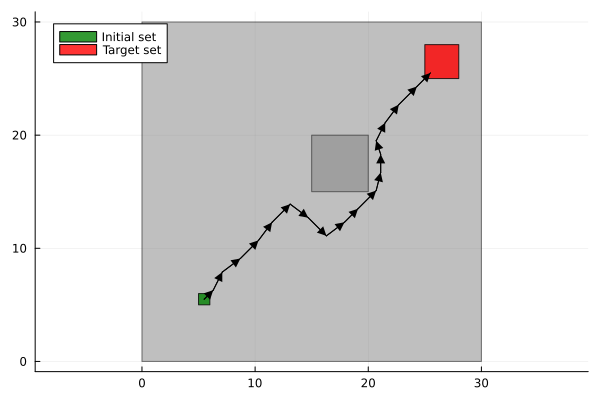

In [7]:
fig = plot(; aspect_ratio = :equal);
#We display the concrete domain
plot!(concrete_system.X; color = :grey, opacity = 0.5, label = "");

#We display the abstract domain
plot!(abstract_system.Xdom; color = :blue, opacity = 0.5, efficient = false, label = "");

#We display the concrete specifications
plot!(concrete_problem.initial_set; color = :green, opacity = 0.8, label = "Initial set");
plot!(
    concrete_problem.target_set;
    dims = [1, 2],
    color = :red,
    opacity = 0.8,
    label = "Target set",
);

#We display the concrete trajectory
plot!(cost_control_trajectory; ms = 0.5)

# Display the abstraction and Lyapunov-like function

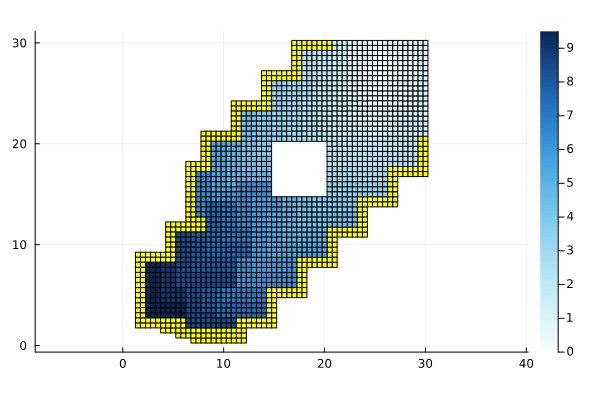

In [8]:
fig = plot(; aspect_ratio = :equal);
plot!(
    abstract_system;
    dims = [1, 2],
    cost = true,
    lyap_fun = optimizer.lyap_fun,
    label = false,
)

# Display the Bellman-like value function (heuristic)

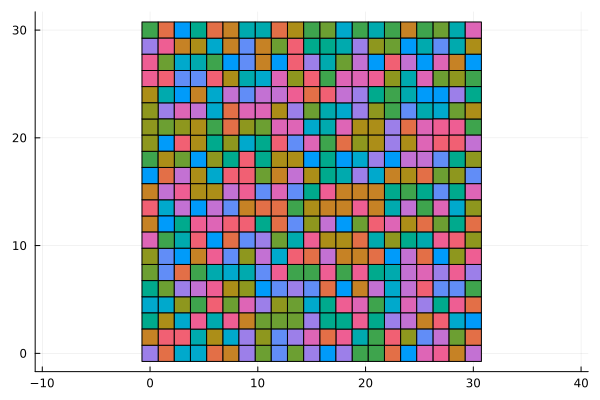

In [9]:
fig = plot(; aspect_ratio = :equal)
plot!(
    optimizer.abstract_system_heuristic;
    arrowsB = false,
    dims = [1, 2],
    cost = true,
    lyap_fun = optimizer.bell_fun,
    label = "",
    efficient = false,
)

# Display the results of the A* algorithm

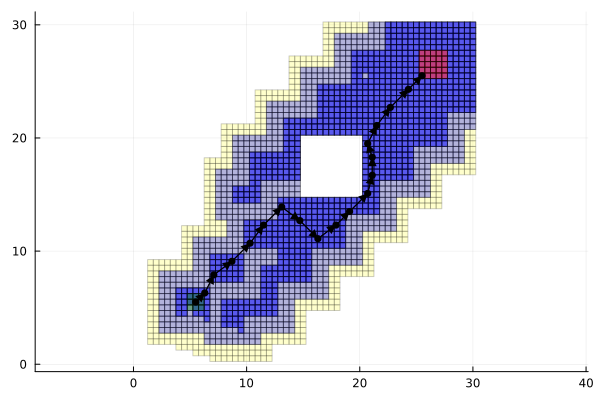

In [10]:
fig = plot(; aspect_ratio = :equal)
plot!(optimizer.lazy_search_problem)
plot!(cost_control_trajectory; color = :black)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*